In [1]:
using JSON3
using JLD2
using CSV
using DataFrames
using Statistics
using CairoMakie
using Unitful
using UnitfulAtomic

In [2]:
files = filter(endswith(".json"), readdir())

58-element Vector{String}:
 "eval_pbe_Ag_fcc.json"
 "eval_pbe_AlAs_b3.json"
 "eval_pbe_AlN_b3.json"
 "eval_pbe_AlP_b3.json"
 "eval_pbe_Al_fcc.json"
 "eval_pbe_Au_fcc.json"
 "eval_pbe_BAs_b3.json"
 "eval_pbe_BN_b3.json"
 "eval_pbe_BP_b3.json"
 "eval_pbe_Ba_bcc.json"
 ⋮
 "eval_pbe_Ta_bcc.json"
 "eval_pbe_TiC_b1.json"
 "eval_pbe_TiN_b1.json"
 "eval_pbe_VC_b1.json"
 "eval_pbe_VN_b1.json"
 "eval_pbe_V_bcc.json"
 "eval_pbe_W_bcc.json"
 "eval_pbe_ZrC_b1.json"
 "eval_pbe_ZrN_b1.json"

In [3]:
raw_data = [file=>JSON3.read(read(file, String)) for file in files];

In [4]:
df_sol58lc = let
    csv_path = "../../sol58lc/Sol58LC.csv"
    df = DataFrame(CSV.File(csv_path))
    df = rename(df, :sysnames => "name")
    df[:, [:name]]
end

Row,name
,String15
1,Li_bcc
2,Na_bcc
3,K_bcc
4,Rb_bcc
5,Ca_fcc
6,Sr_fcc
7,Ba_bcc
8,V_bcc
9,Nb_bcc


In [5]:
function build_dataframe(raw_data)
    keys = [:name, :a_opt,
            :dvol, :n_atoms, :kgrid, :occupation, :Ecut, :lattice, :damping_value, 
            :species, :eigenvalues, :symmetries_respect_rgrid, :occupation_threshold,
            :n_iter, :spin_polarization, :εF, :kweights, :smearing, :atomic_positions,
            :fft_size, :n_kpoints, :n_bands_converge, :kcoords_cart, :temperature,
            :variational, :use_symmetries_for_kpoint_reduction, :element_symbols,
            :history_Δρ, :runtime_ns, :n_bands, :kcoords, :converged, :energies,
            :symmetries_translations, :n_spin_components, :n_matvec, :τ, :recip_lattice,
            :model_name, :n_electrons, :n_dim, :atomic_positions_cart, :timedout,
            :symmetries_rotations, :algorithm, :history_Etot, :ρ, :scfres_extra_keys, :terms]
    cols = [key => [data[key] for (_, data) in raw_data] for key in keys]
    cols = push!(cols, :file => [file for (file, _) in raw_data])
    df = DataFrame(cols...)
    
    # Convert total SCF time from nanoseconds to seconds
    df = transform(df, :runtime_ns => (x -> x / 10^9) => :runtime_s)

    # Bring into original Sol58LC order
    df = leftjoin(df, df_sol58lc, on=:name)

    df
end

df = build_dataframe(raw_data)
size(df)

(58, 51)

In [6]:
df_small = df[:, [:name, :a_opt, :Ecut, :fft_size, :kgrid, :n_kpoints, :n_electrons, :n_iter, :runtime_s]]
show(df_small, allrows=true, allcols=true)

58×9 DataFrame
 Row │ name        a_opt     Ecut   fft_size      kgrid                        n_kpoints  n_electrons  n_iter  runtime_s 
     │ String      Float64   Int64  Array…        String                       Int64      Int64        Int64   Float64   
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ Li_bcc       6.4946      37  [36, 36, 36]  MonkhorstPack([18, 18, 18])        195            3      10   14.1902
   2 │ Na_bcc       7.9392      44  [45, 45, 45]  MonkhorstPack([15, 15, 15])        120            9      16   42.0262
   3 │ K_bcc        9.98411     37  [50, 50, 50]  MonkhorstPack([12, 12, 12])         72            9      14   37.5537
   4 │ Rb_bcc      10.7089      23  [45, 45, 45]  MonkhorstPack([11, 11, 11])         56            9      15   23.1768
   5 │ Ca_fcc      10.4419      34  [45, 45, 45]  MonkhorstPack([14, 14, 14])        104           10      15   63.6725
   6 │ Sr_fcc      

In [7]:
describe(df_small)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Any,Any,Union…,Any,Int64,DataType
1,name,,Ag_fcc,,ZrN_b1,0,String
2,a_opt,8.40841,5.20294,8.23342,12.5819,0,Float64
3,Ecut,38.931,18,41.5,49,0,Int64
4,fft_size,"[38.569, 38.569, 38.569]","[24, 24, 24]",,"[60, 60, 60]",0,"Array{Int64, CodeUnits{UInt8, String}, SubArray{UInt64, 1, Vector{UInt64}, Tuple{UnitRange{Int64}}, true}}"
5,kgrid,,"MonkhorstPack([11, 11, 11])",,"MonkhorstPack([21, 21, 21])",0,String
6,n_kpoints,178.207,56,183.5,506,0,Int64
7,n_electrons,14.8793,3,16.0,28,0,Int64
8,n_iter,16.7414,10,15.5,32,0,Int64
9,runtime_s,50.6237,7.03099,47.8972,121.99,0,Float64


## Extract band gaps

In [8]:
function estimate_bandgap(eigenvalues, εF)
    homo = maximum(eigenvalues[eigenvalues .≤ εF])
    lumo = minimum(eigenvalues[eigenvalues .> εF])
    lumo - homo
end

estimate_bandgap(df.eigenvalues[1], df.εF[1])

0.0018720342944340551

In [9]:
df_gaps = select(
    df,
    :name,
    [:eigenvalues, :εF] => ByRow(estimate_bandgap) => :gap
)
df_gaps = transform(df_gaps, :gap => ByRow(x -> uconvert(u"eV", x * u"hartree")) => :gap_eV)

Row,name,gap,gap_eV
,String,Float64,Quantity…
1,Li_bcc,0.00187203,0.0509406 eV
2,Na_bcc,0.0025857,0.0703604 eV
3,K_bcc,0.00241817,0.0658019 eV
4,Rb_bcc,0.00281885,0.0767048 eV
5,Ca_fcc,0.000454948,0.0123798 eV
6,Sr_fcc,0.000711935,0.0193727 eV
7,Ba_bcc,0.0017066,0.046439 eV
8,V_bcc,0.000309602,0.0084247 eV
9,Nb_bcc,0.000543405,0.0147868 eV


In [10]:
show(sort(df_gaps, :gap_eV, rev=true), allrows=true)

58×3 DataFrame
 Row │ name        gap          gap_eV        
     │ String      Float64      Quantity…     
─────┼────────────────────────────────────────
   1 │ LiF_b1      0.326774        8.89197 eV
   2 │ LiCl_b1     0.229862        6.25485 eV
   3 │ NaF_b1      0.224844        6.11831 eV
   4 │ NaCl_b1     0.18346         4.99219 eV
   5 │ BN_b3       0.167316         4.5529 eV
   6 │ MgO_b1      0.164434        4.47449 eV
   7 │ C_diamond   0.153707        4.18257 eV
   8 │ CaO_b1      0.135379        3.68384 eV
   9 │ AlN_b3      0.123591        3.36309 eV
  10 │ LiH_b1      0.112208        3.05334 eV
  11 │ MgS_b1      0.101053        2.74979 eV
  12 │ AlP_b3      0.0597438       1.62571 eV
  13 │ GaN_b3      0.0577865       1.57245 eV
  14 │ GaP_b3      0.0571991       1.55647 eV
  15 │ AlAs_b3     0.0562105       1.52957 eV
  16 │ SiC_b3      0.0520509       1.41638 eV
  17 │ BP_b3       0.0466874       1.27043 eV
  18 │ BAs_b3      0.04512         1.22778 eV
  19 │ InAs_b3  

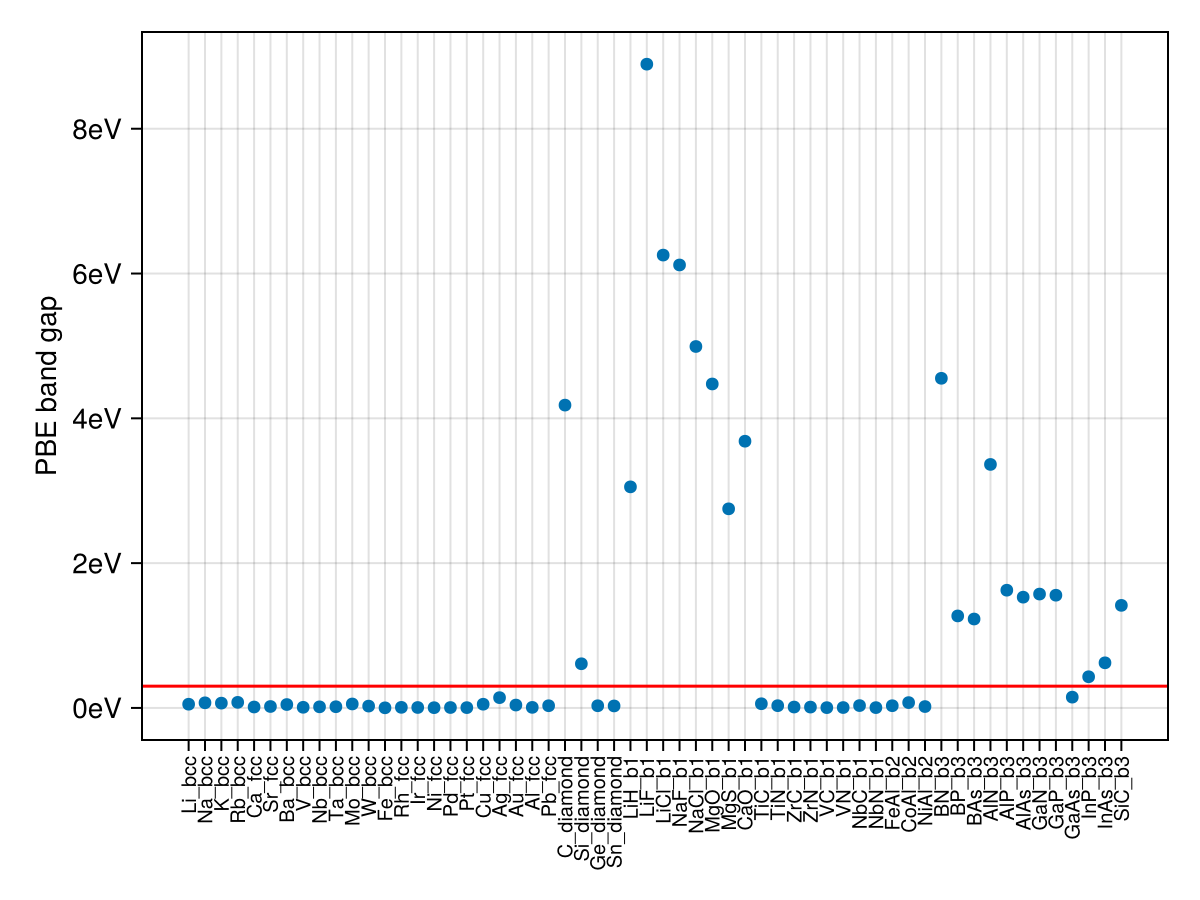

In [11]:
let
    fig = Figure()
    ax = Makie.Axis(
        fig[1, 1],
        ylabel="PBE band gap",
        xticks=(1:58, df_gaps.name),
        xticklabelrotation=π/2,
        xticklabelsize=10,
    )
    scatter!(ax, df_gaps.gap_eV)
    hlines!([0.3], color=:red)
    fig
end

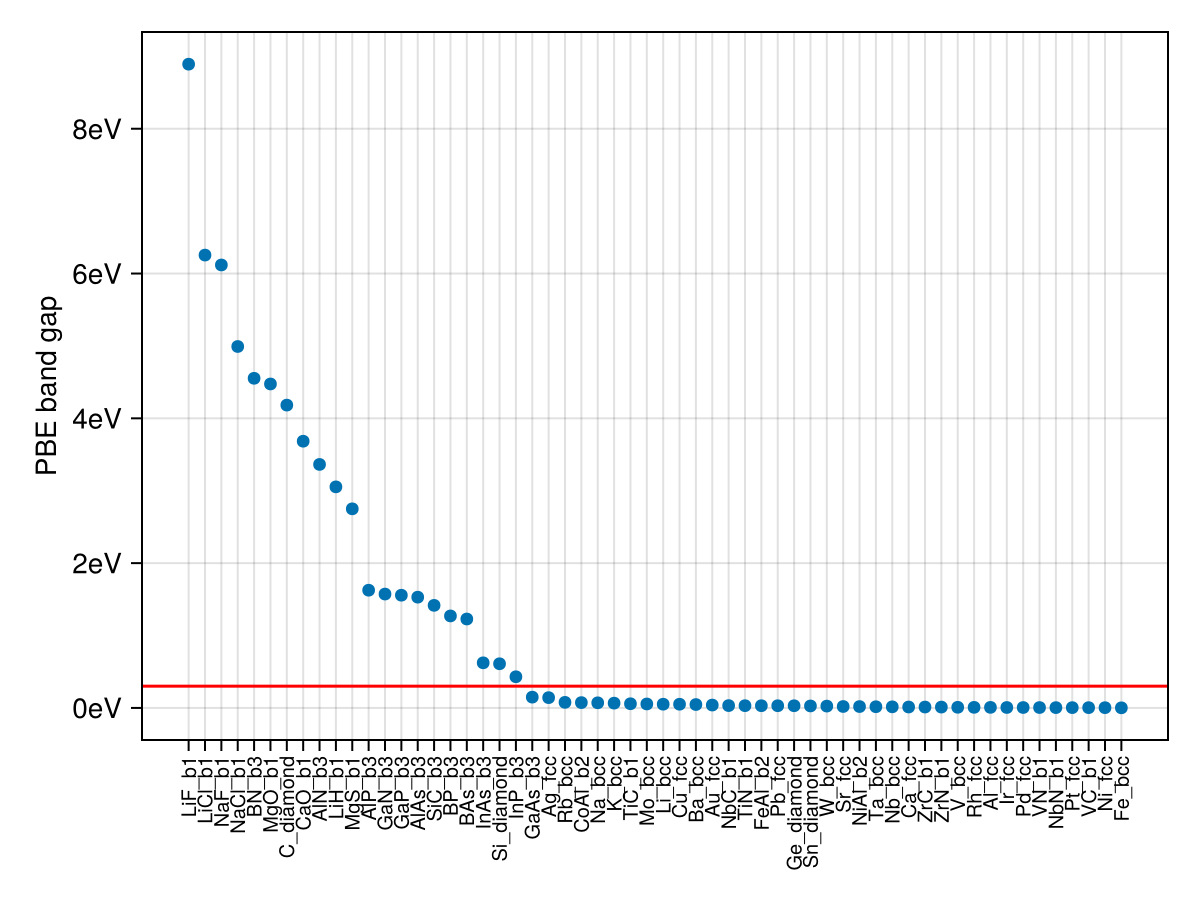

In [12]:
let df_gaps_sort = sort(df_gaps, :gap_eV, rev=true)

    fig = Figure()
    ax = Makie.Axis(
        fig[1, 1],
        ylabel="PBE band gap",
        xticks=(1:58, df_gaps_sort.name),
        xticklabelrotation=π/2,
        xticklabelsize=10,
    )
    scatter!(ax, df_gaps_sort.gap_eV)
    hlines!([0.3], color=:red)
    fig
end

## Densities

In [14]:
using DFTK

In [15]:
density_targets = [
    # "Li_bcc",
    # "LiF_b1",
    "Si_diamond",
    "NaCl_b1",
    "Al_fcc",
    "V_bcc",
]

4-element Vector{String}:
 "Si_diamond"
 "NaCl_b1"
 "Al_fcc"
 "V_bcc"

In [16]:
df_densities = DataFrame()
for name in density_targets
    print(name, " ")
    jld2_path = "eval_pbe_$(name).jld2"
    scfres = @time load_scfres(jld2_path; skip_hamiltonian=true)
    density = DFTK.LibxcDensities(scfres.basis, 1, scfres.ρ, nothing)
    push!(df_densities, (; name, scfres, density))
end

Si_diamond   8.322209 seconds (16.23 M allocations: 985.929 MiB, 4.78% gc time, 65.59% compilation time: 6% of which was recompilation)
NaCl_b1   5.508507 seconds (17.10 M allocations: 1.225 GiB, 10.28% gc time, 0.20% compilation time: 58% of which was recompilation)
Al_fcc   8.223934 seconds (3.11 M allocations: 273.126 MiB, 0.62% gc time)
V_bcc 

┌ Warning: Negative ρcore detected: -3.125071932097344e-8
└ @ DFTK /home/schmitz/.julia/packages/DFTK/n2IL4/src/terms/xc.jl:39


 16.229956 seconds (9.69 M allocations: 857.561 MiB, 1.69% gc time, 0.35% compilation time: 74% of which was recompilation)


In [17]:
function reduced_density_gradient(density)
    # s² = σ / (ρ^(4 / 3) * 2cbrt(3π^2))^2
    σ = density.σ_real
    ρ = density.ρ_real
    s = sqrt.(σ ./ (ρ .^ (4 / 3) .* (2 * cbrt(3 * π^2))) .^ 2)
    s
end

reduced_density_gradient (generic function with 1 method)

In [18]:
df_densities = transform(df_densities, :density => ByRow(reduced_density_gradient) => :s);

In [19]:
extrema.(df_densities.s)

4-element Vector{Tuple{Float64, Float64}}:
 (2.338218905231134e-9, 5.59708993074917)
 (3.158964745893136e-16, 6.072506108277785)
 (1.0589567415828318e-16, 4.099206546624468)
 (1.5901418573260504e-15, 1.3495201100506444)

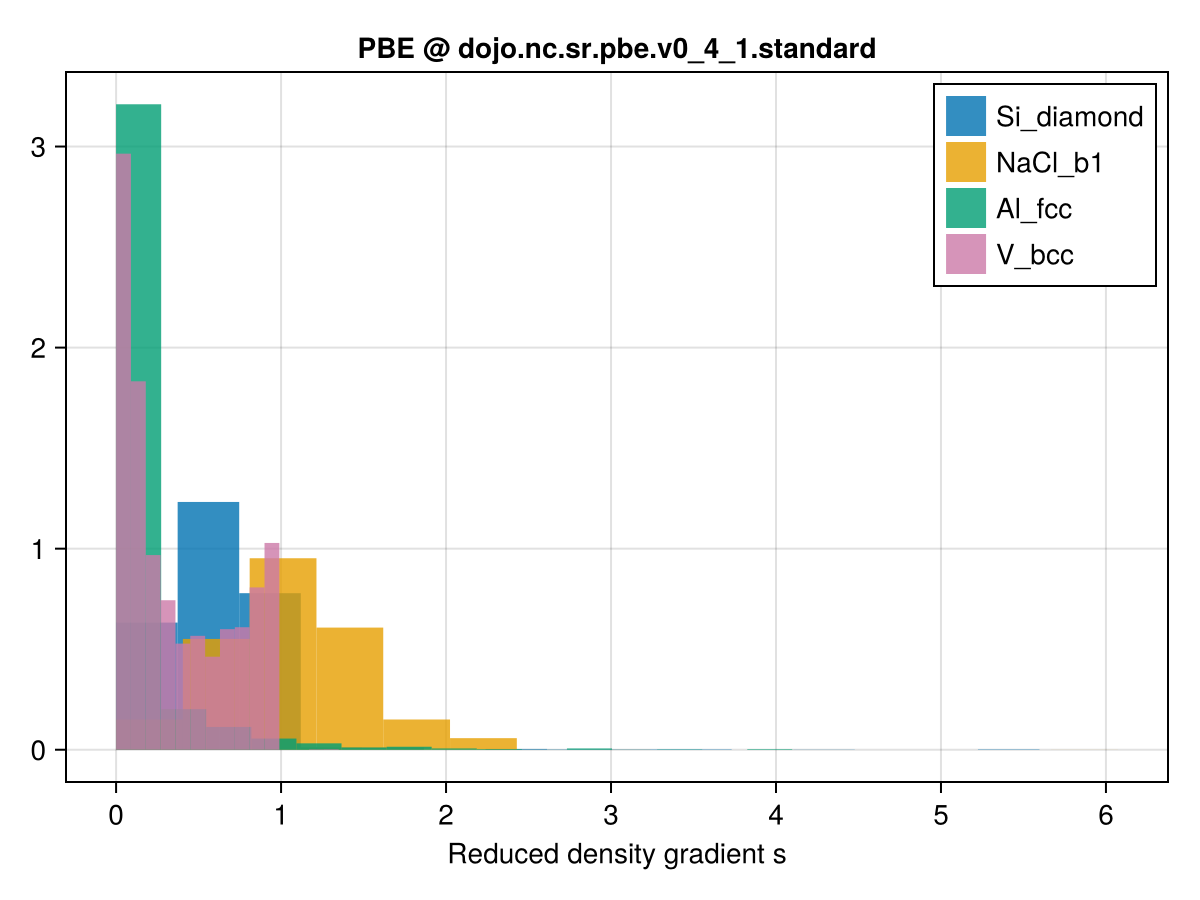

In [23]:
let fig = Figure()
    ax = Axis(fig[1, 1], xlabel="Reduced density gradient s", title="PBE @ dojo.nc.sr.pbe.v0_4_1.standard")
    for row in eachrow(df_densities)
        hist!(ax, row.s[:], normalization=:pdf, label=row.name)
    end
    axislegend(ax)
    fig
end

┌ Warning: Using a nested array for raincloud is deprecated. Read raincloud's documentation and update your usage accordingly.
└ @ Makie /home/schmitz/.julia/packages/Makie/Y3ABD/src/basic_recipes/raincloud.jl:195


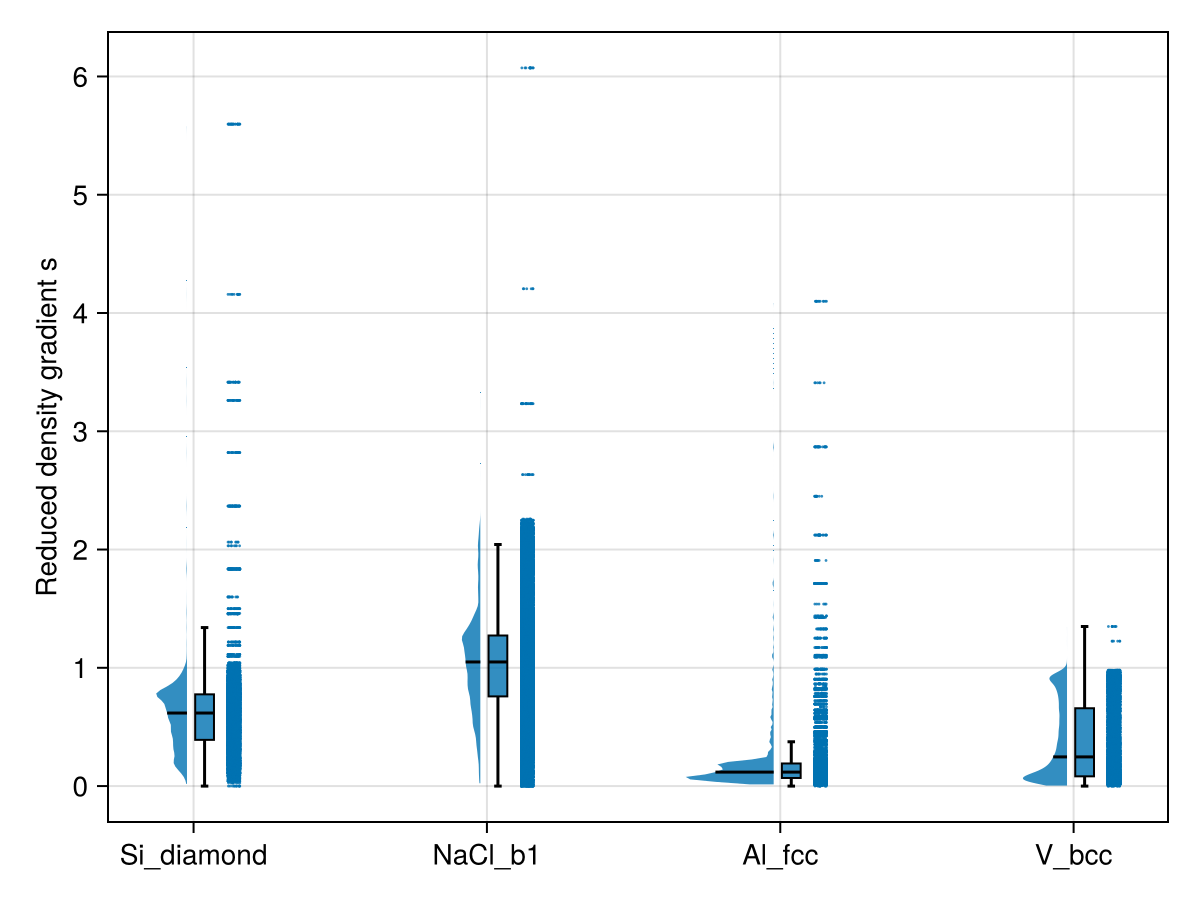

In [26]:
let colors = Makie.wong_colors()
    fig = Figure()
    ax = Makie.Axis(
        fig[1,1],
        ylabel="Reduced density gradient s",
        xticks=(1:length(df_densities.name), df_densities.name),
    )
    rainclouds!(ax, df_densities.name, [s[:] for s in df_densities.s], violin_limits=extrema)
    fig
end

In [34]:
for scfres in df_densities.scfres
    @show scfres.basis.model.positions
end

scfres.basis.model.positions = StaticArraysCore.SVector{3, Float64}[[0.0, 0.0, -0.0], [0.25000000072002204, 0.25000000072002204, 0.25000000072002204]]
scfres.basis.model.positions = StaticArraysCore.SVector{3, Float64}[[0.0, 0.0, -0.0], [-0.49999999966500236, 0.49999999966500236, 0.49999999966500236]]
scfres.basis.model.positions = StaticArraysCore.SVector{3, Float64}[[0.0, 0.0, -0.0]]
scfres.basis.model.positions = StaticArraysCore.SVector{3, Float64}[[-0.0, 0.0, 0.0]]

scfres.basis.model.positions = StaticArraysCore.SVector{3, Float64}[[0.0, 0.0, -0.0], [-0.49999999966500236, 0.49999999966500236, 0.49999999966500236]]
scfres.basis.model.positions = StaticArraysCore.SVector{3, Float64}[[0.0, 0.0, -0.0]]
scfres.basis.model.positions = StaticArraysCore.SVector{3, Float64}[[-0.0, 0.0, 0.0]]


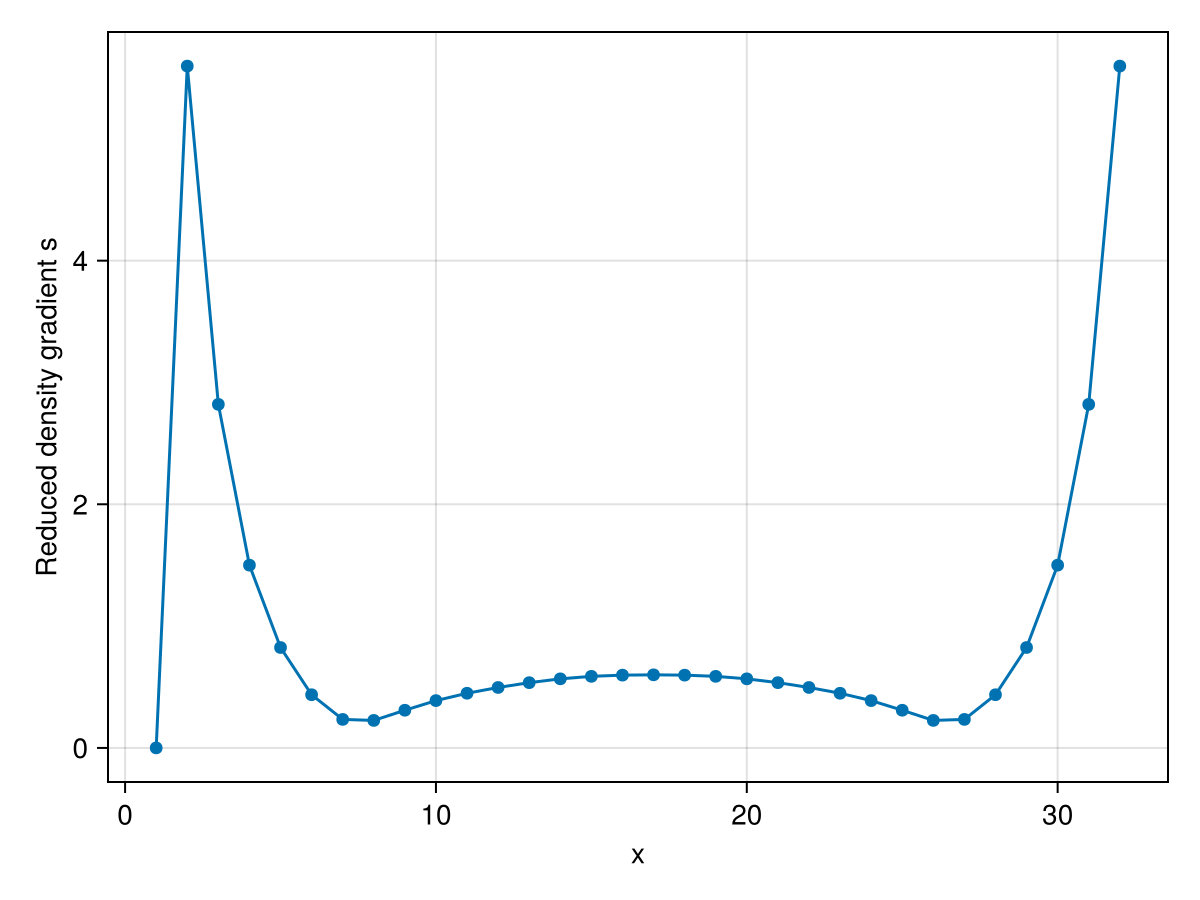

In [44]:
let fig = Figure()
    ax = Makie.Axis(fig[1,1], xlabel="x", ylabel="Reduced density gradient s")
    scatterlines!(ax, df_densities.s[1][1,:,1,1])
    fig
end